In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'CFP.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2013-12-31,810,-529,281,35,90,113,472,752,0,...,2693,0,75,0,441,153,1319,99,-68,139.9
1,2014-03-31,742,-479,263,59,88,119,648,957,0,...,2885,0,182,0,573,153,1481,-50,-53,139.9
2,2014-06-30,907,-587,320,64,108,147,482,820,0,...,2733,0,143,0,495,153,1413,206,-63,139.9
3,2014-09-30,838,-544,294,58,146,111,506,861,0,...,2814,0,145,0,494,153,1427,120,-64,139.9
4,2014-12-31,860,-592,269,41,158,91,518,903,81,...,2847,0,68,0,255,229,1460,110,-55,135.3


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2022-12-31,2023-02-11,121.1,1373,-1141,233,-231,1269,336,1181,...,890,6739,0,28,72,884,214,2518,-53,-292
37,2023-03-31,2023-04-21,118.9,1385,-1238,148,-144,950,413,1258,...,886,6655,0,22,72,938,214,2576,-226,-80
38,2023-06-30,2023-07-21,118.9,1446,-1139,308,-49,861,389,992,...,864,6287,0,64,72,882,160,2368,184,-142
39,2023-09-30,2023-10-21,118.9,1312,-1076,237,-35,838,356,917,...,867,6328,0,84,75,927,163,2399,206,-193
40,2023-12-31,2024-02-11,118.9,1283,-1067,216,-122,627,298,995,...,866,6131,0,111,75,905,115,2313,-8,-172


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,121.1,1373,-1141,233,-231,1269,336,1181,...,6739,0,28,72,884,214,2518,-53,-292,1.357405
37,2023-03-31,2023-04-21,118.9,1385,-1238,148,-144,950,413,1258,...,6655,0,22,72,938,214,2576,-226,-80,1.352063
38,2023-06-30,2023-07-21,118.9,1446,-1139,308,-49,861,389,992,...,6287,0,64,72,882,160,2368,184,-142,1.343352
39,2023-09-30,2023-10-21,118.9,1312,-1076,237,-35,838,356,917,...,6328,0,84,75,927,163,2399,206,-193,1.341033
40,2023-12-31,2024-02-11,118.9,1283,-1067,216,-122,627,298,995,...,6131,0,111,75,905,115,2313,-8,-172,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2022-12-31,2023-02-11,121.1,1373,-1141,233,-231,1269,336,1181,...,6739,0,28,72,884,214,2518,-53,-292,1.357405
37,2023-03-31,2023-04-21,118.9,1385,-1238,148,-144,950,413,1258,...,6655,0,22,72,938,214,2576,-226,-80,1.352063
38,2023-06-30,2023-07-21,118.9,1446,-1139,308,-49,861,389,992,...,6287,0,64,72,882,160,2368,184,-142,1.343352
39,2023-09-30,2023-10-21,118.9,1312,-1076,237,-35,838,356,917,...,6328,0,84,75,927,163,2399,206,-193,1.341033
40,2023-12-31,2024-02-11,118.9,1283,-1067,216,-122,627,298,995,...,6131,0,111,75,905,115,2313,-8,-172,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-02-17,29.750000,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,0.510212,0.489788,28.672566,inf,36.0,4.483051,0.346914,0.04321,0.051987,0.101892
1,2014-02-24,29.370001,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,0.510212,0.489788,28.672566,inf,36.0,4.483051,0.346914,0.04321,0.051987,0.101892
2,2014-03-03,29.290001,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,0.510212,0.489788,28.672566,inf,36.0,4.483051,0.346914,0.04321,0.051987,0.101892
3,2014-03-10,27.219999,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,0.510212,0.489788,28.672566,inf,36.0,4.483051,0.346914,0.04321,0.051987,0.101892
4,2014-03-17,26.500000,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,0.510212,0.489788,28.672566,inf,36.0,4.483051,0.346914,0.04321,0.051987,0.101892


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-02-17,29.750000,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,4.483051,0.346914,0.04321,0.051987,0.101892,29.728750,3.029130,1.284576,1.663897,6.230576
1,2014-02-24,29.370001,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,4.483051,0.346914,0.04321,0.051987,0.101892,29.349022,2.990439,1.268168,1.647489,6.150993
2,2014-03-03,29.290001,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,4.483051,0.346914,0.04321,0.051987,0.101892,29.269079,2.982293,1.264713,1.644034,6.134238
3,2014-03-10,27.219999,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,4.483051,0.346914,0.04321,0.051987,0.101892,27.200556,2.771527,1.175333,1.554654,5.700715
4,2014-03-17,26.500000,2013-12-31,810.0,1.000715,9.821301,139.9,668.0,4.774839,90.0,...,4.483051,0.346914,0.04321,0.051987,0.101892,26.481071,2.698217,1.144244,1.523565,5.549925


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

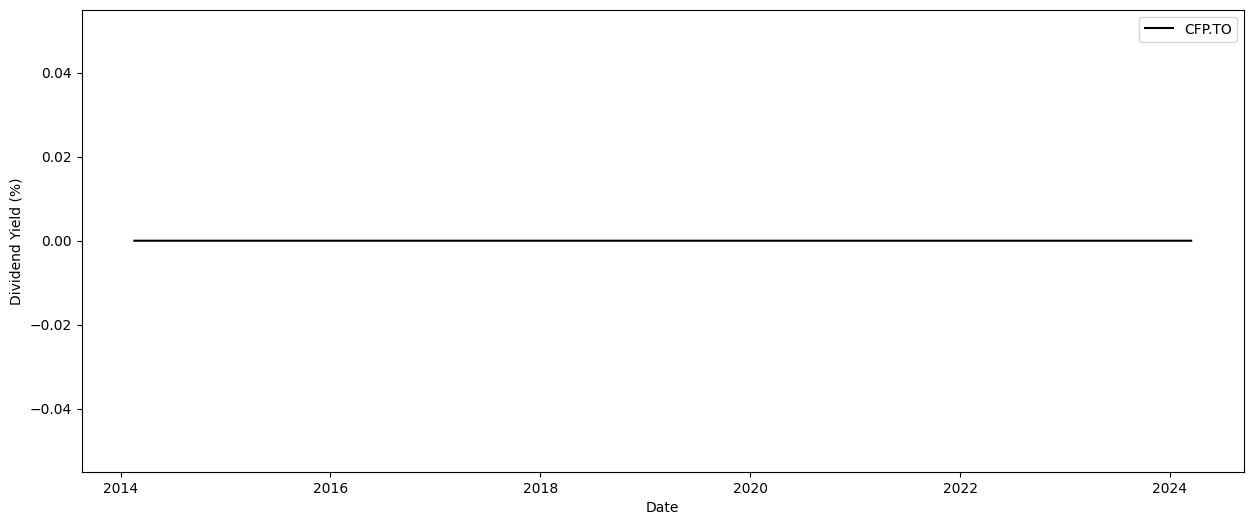

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.549757
share_price      1.000000
Name: share_price, dtype: float64


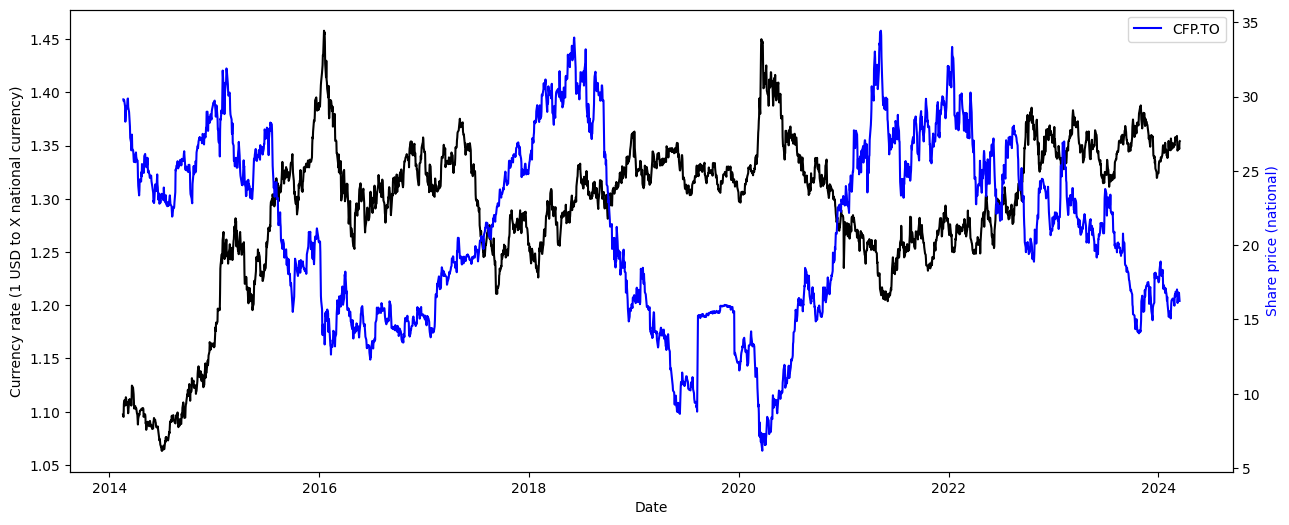

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

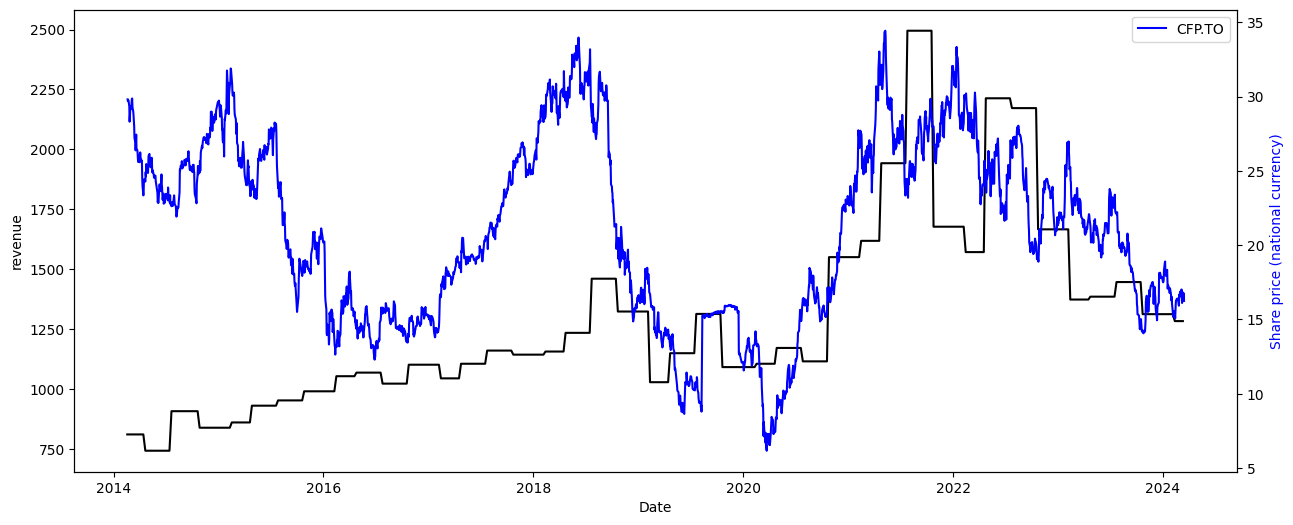

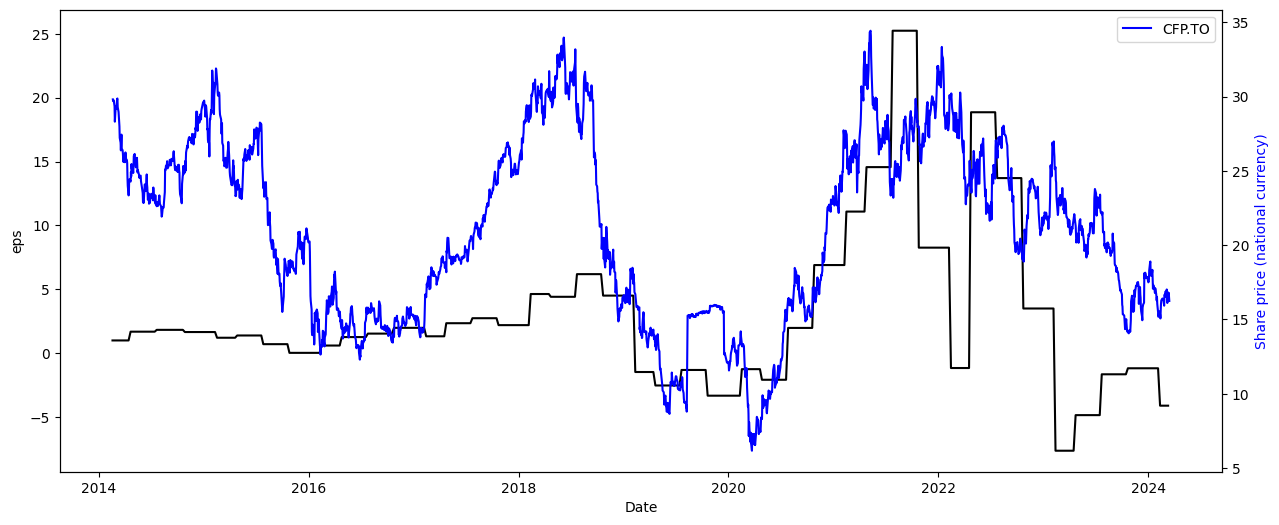

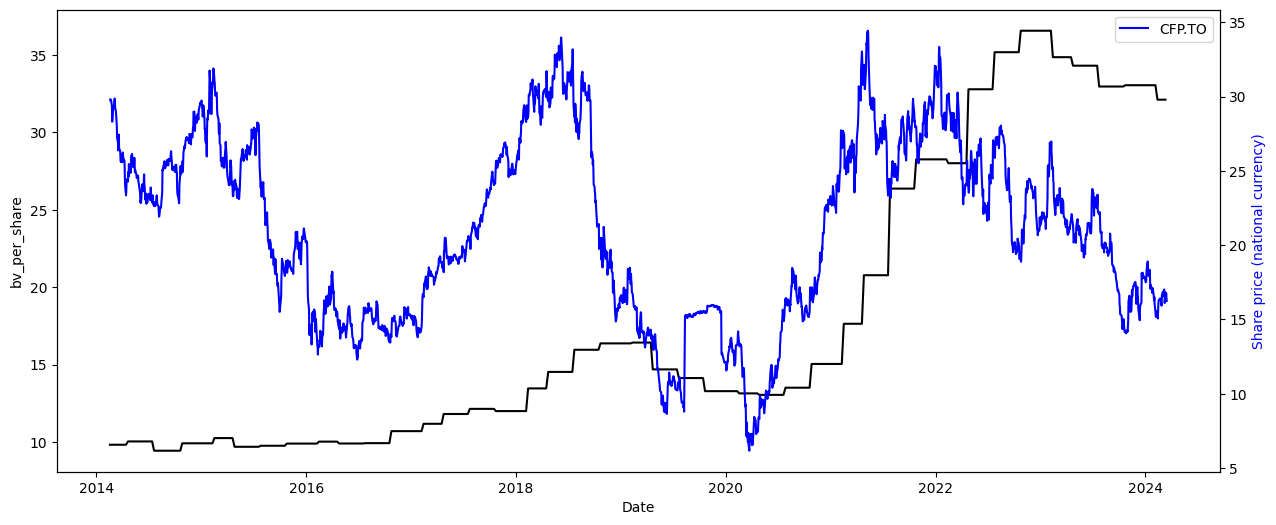

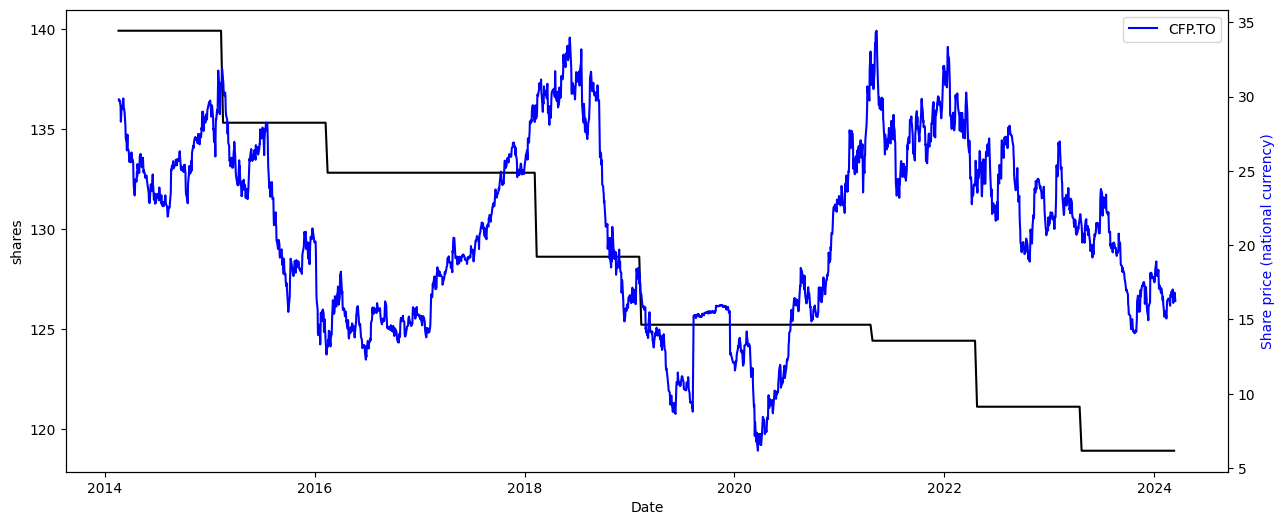

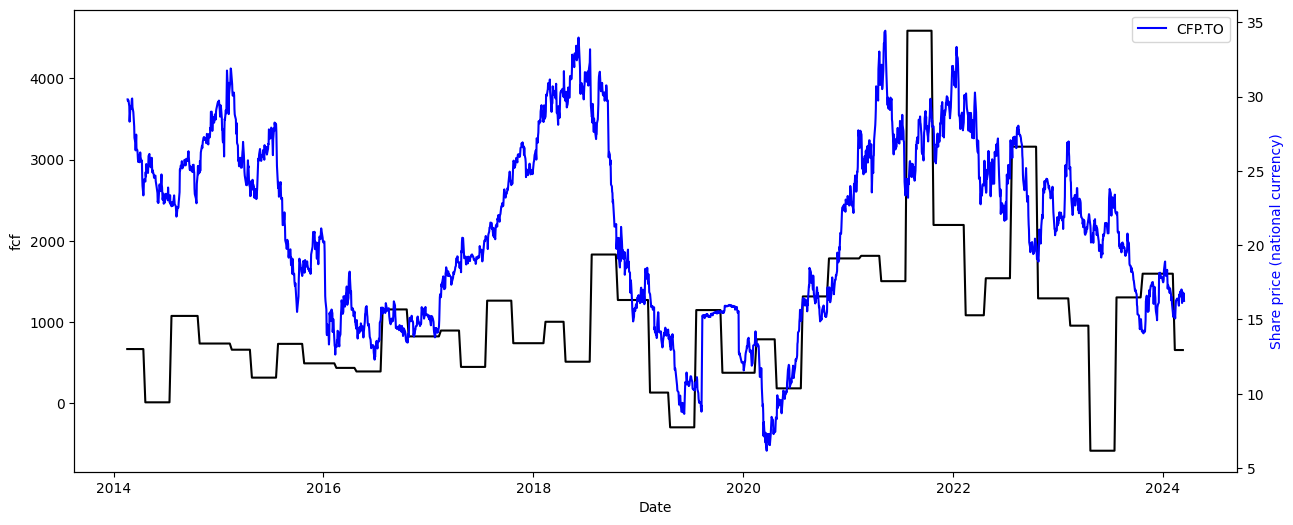

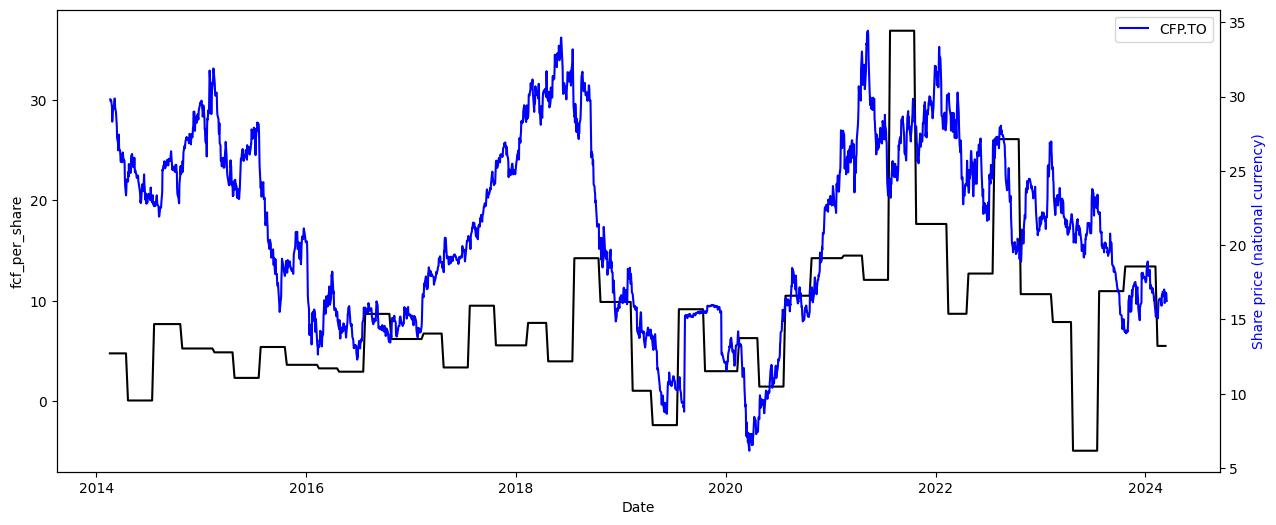

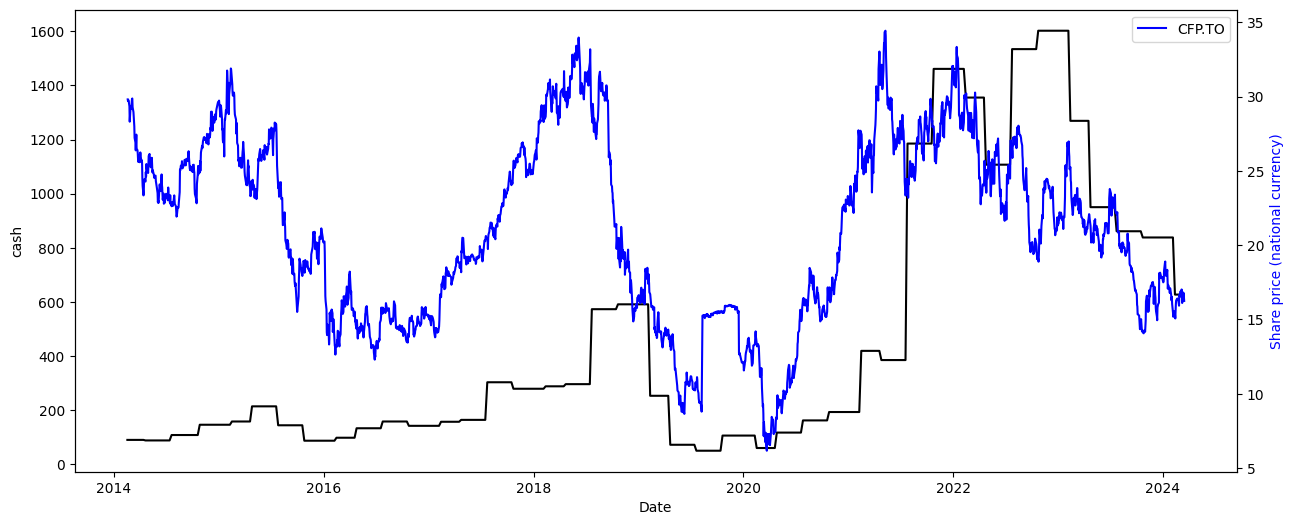

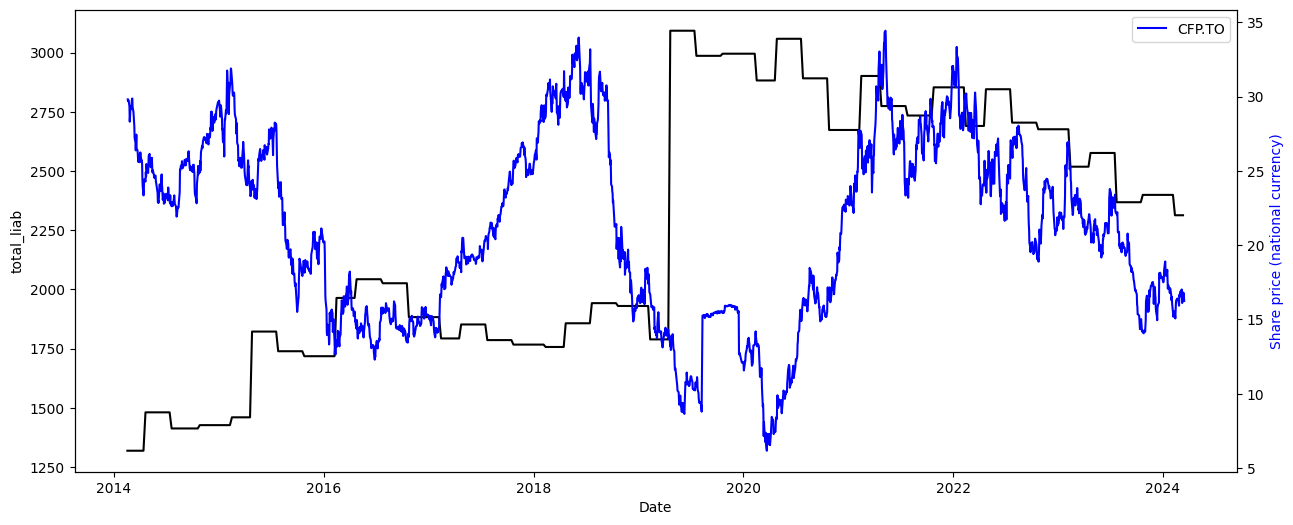

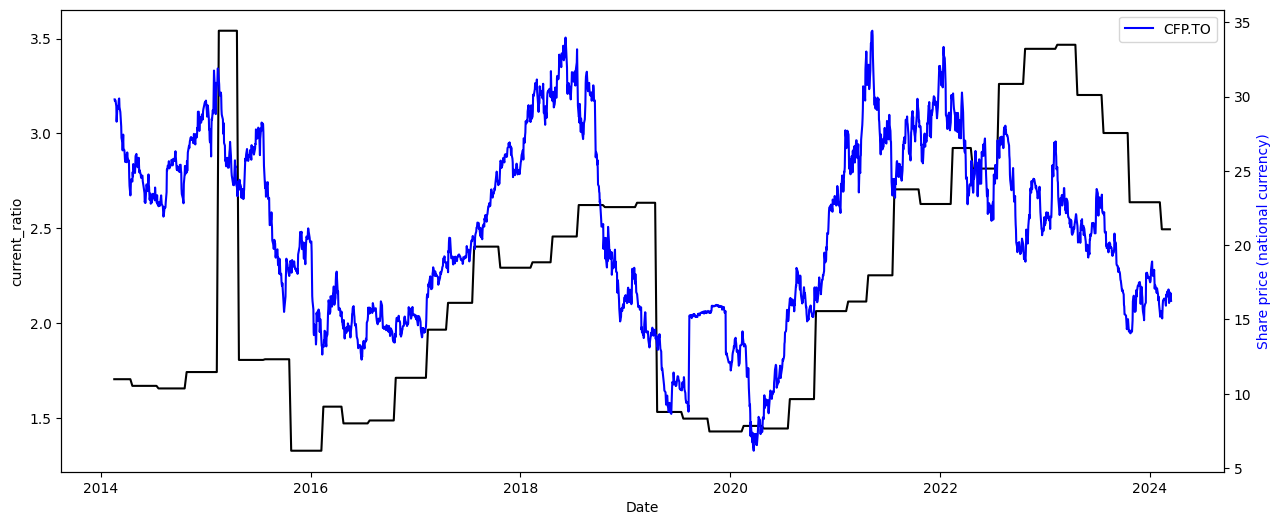

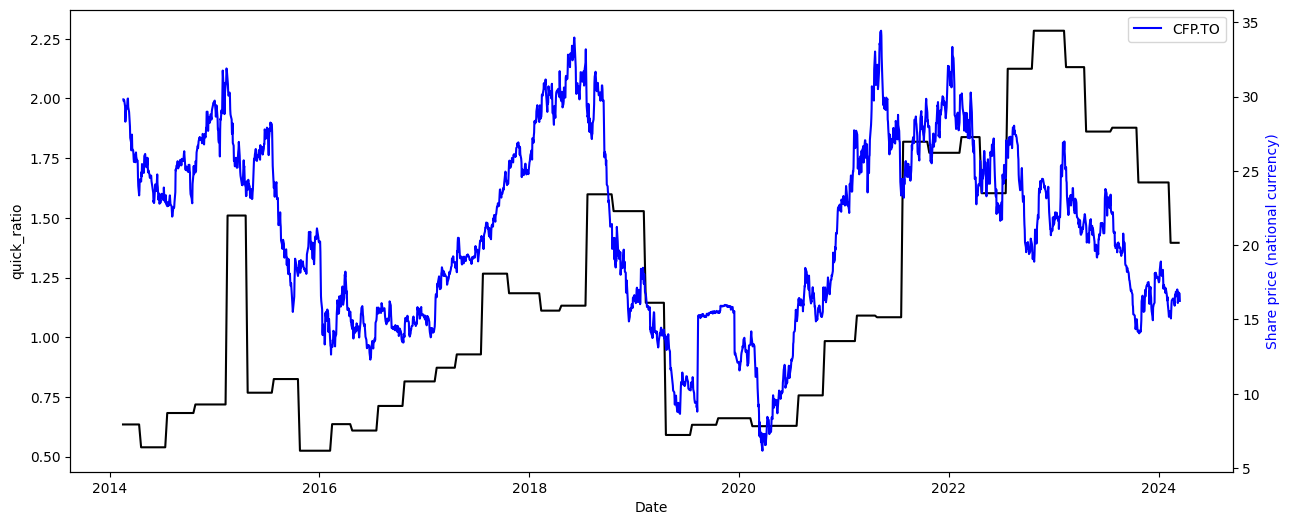

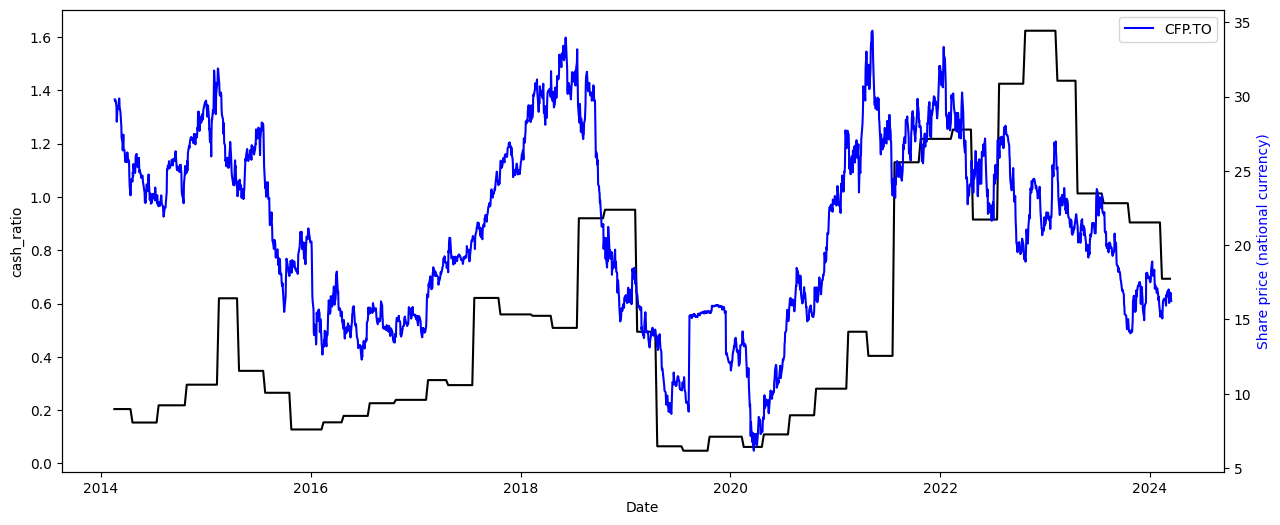

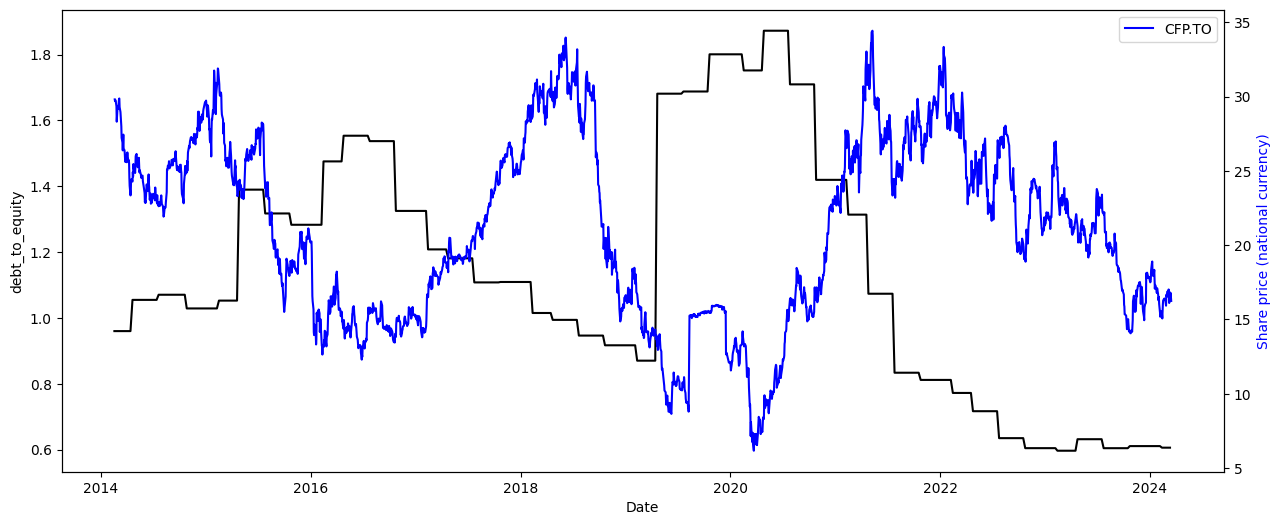

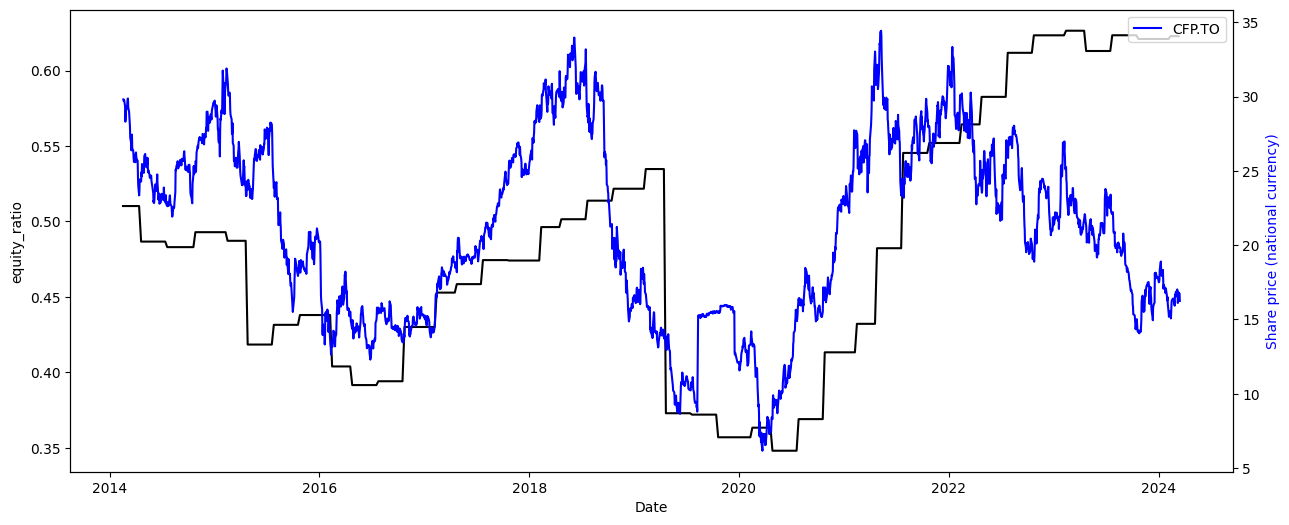

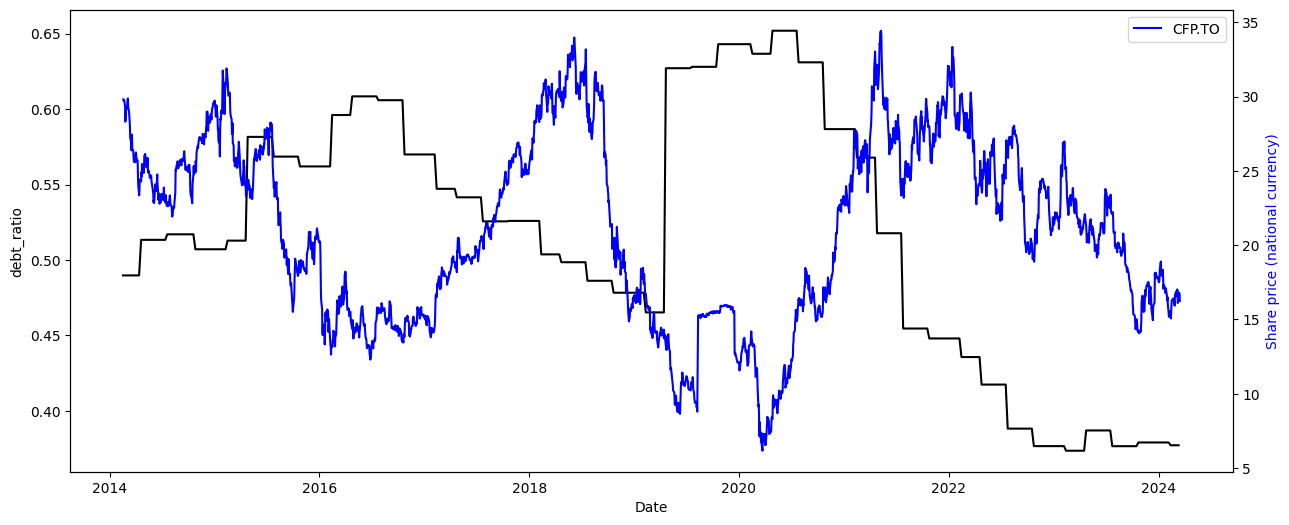

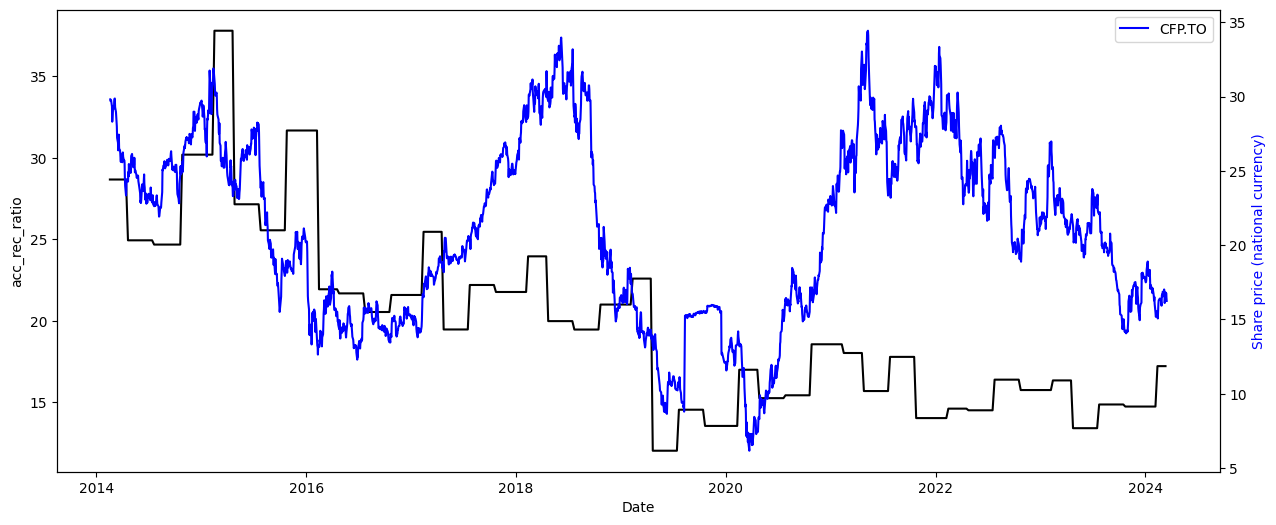

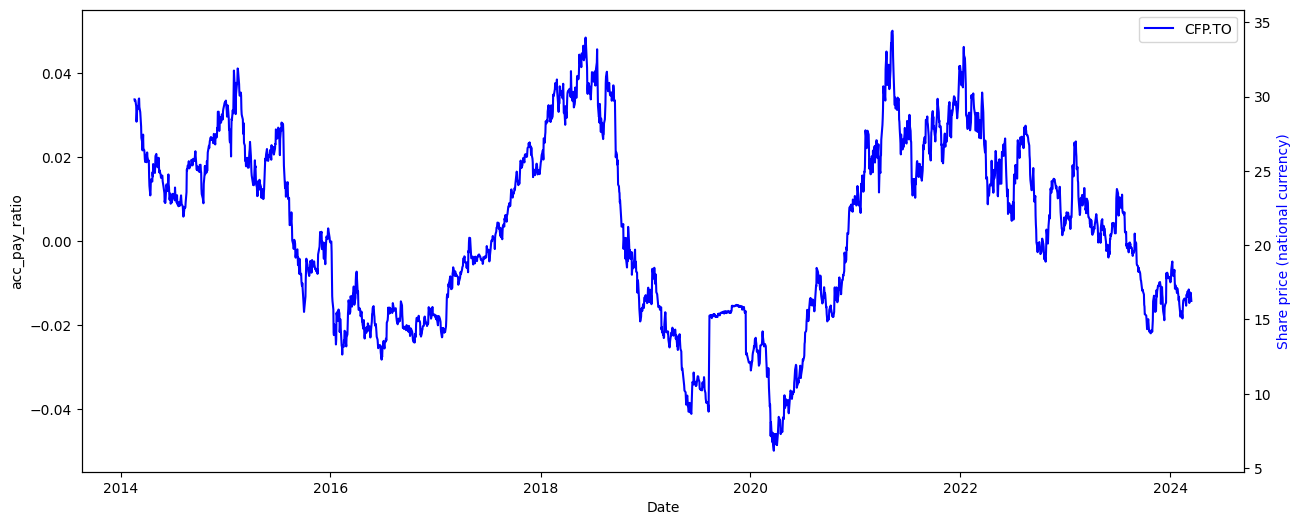

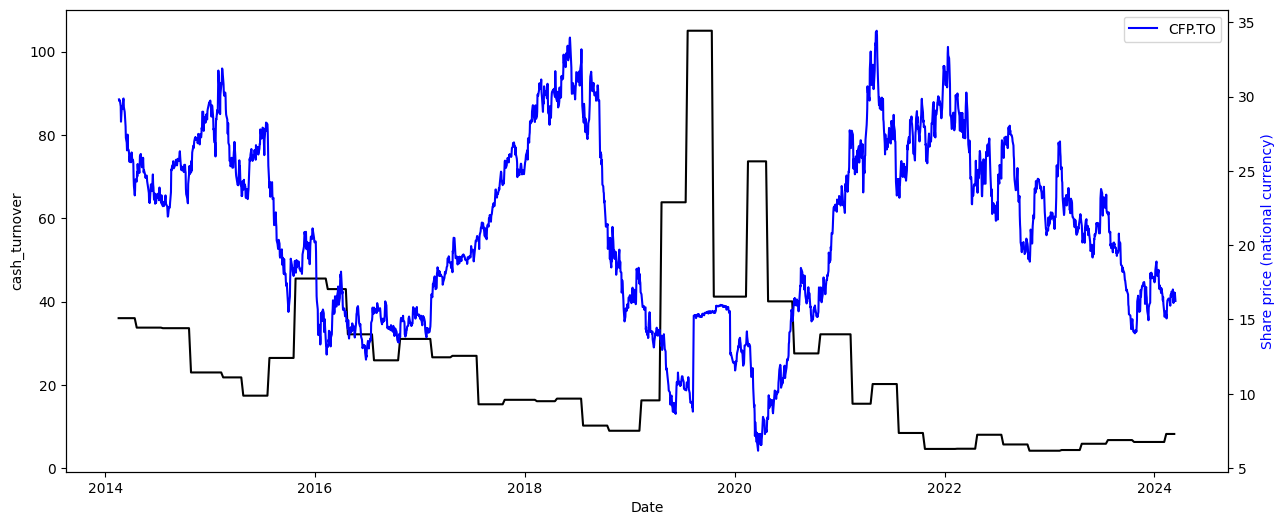

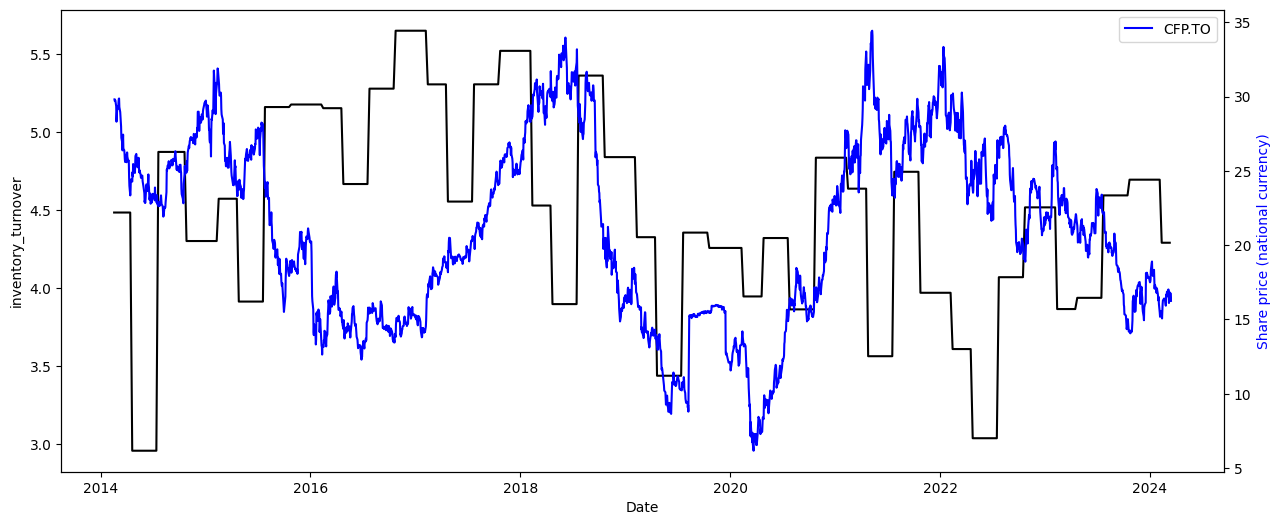

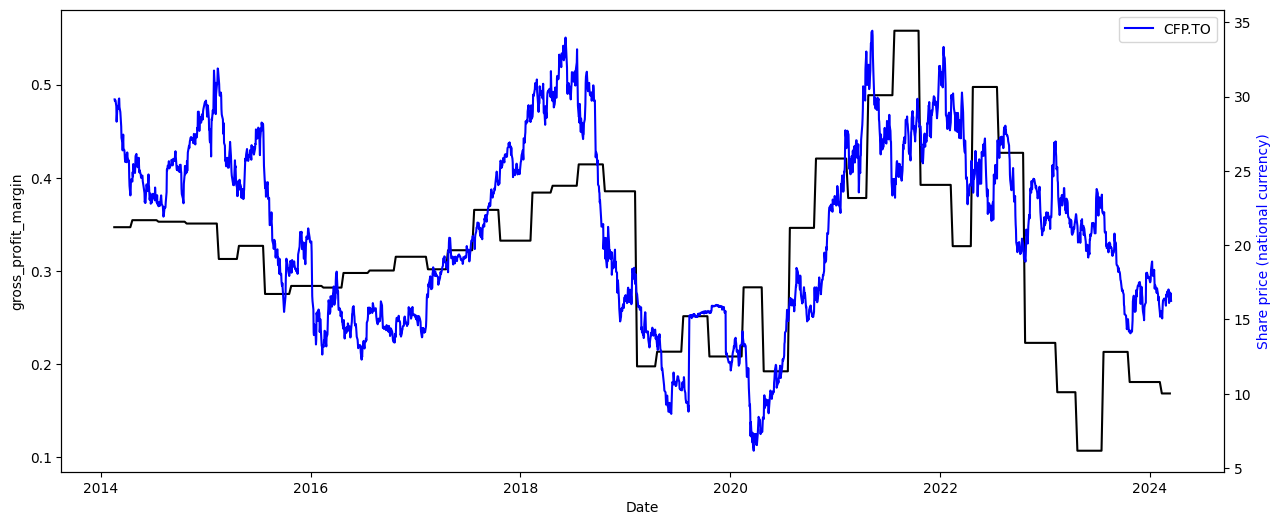

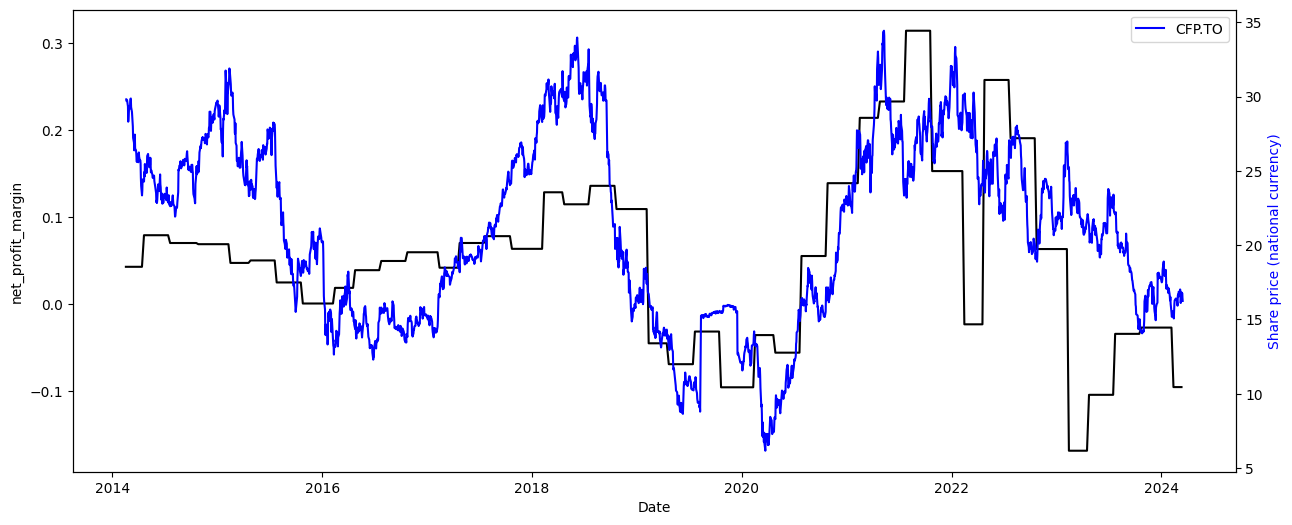

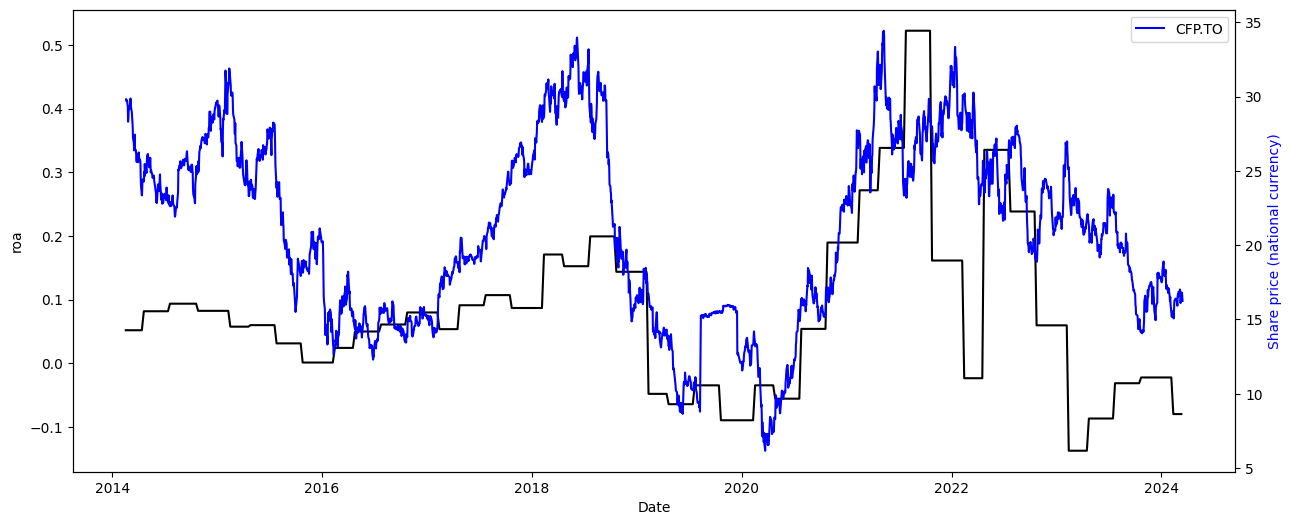

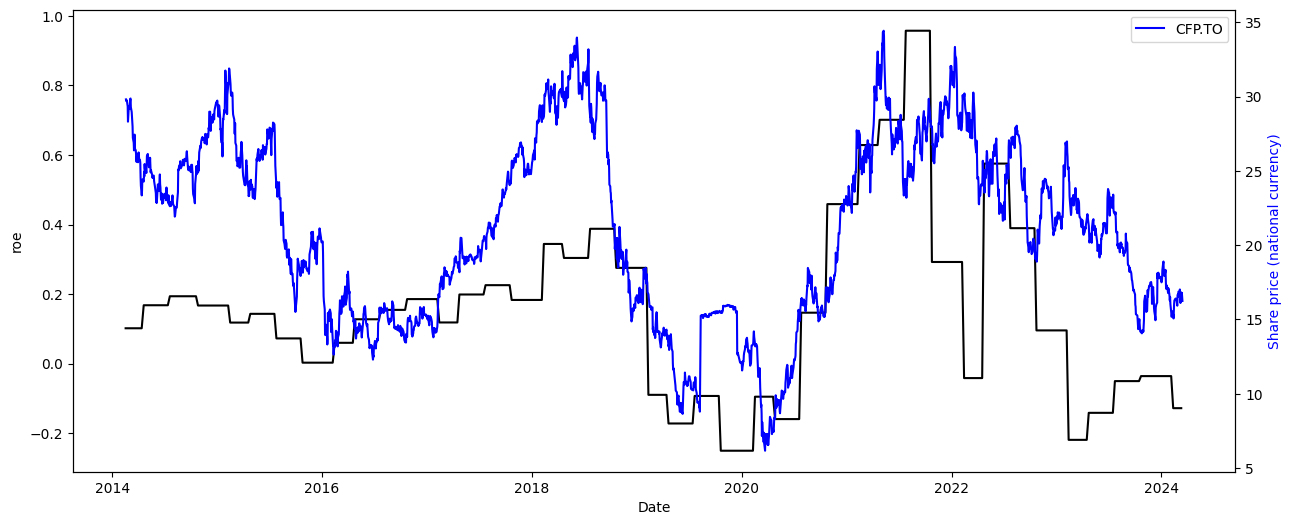

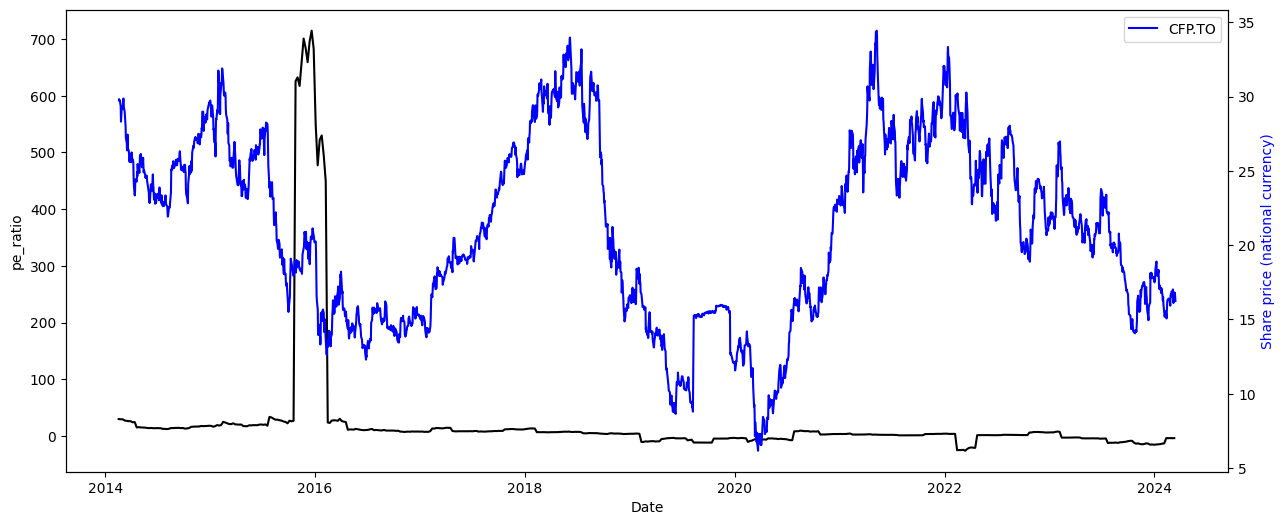

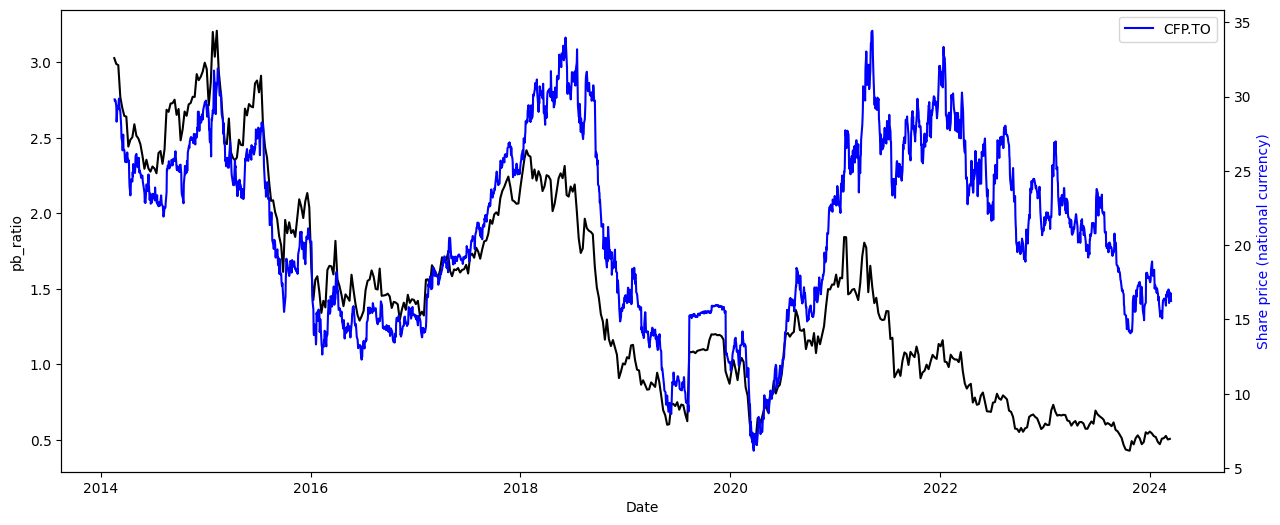

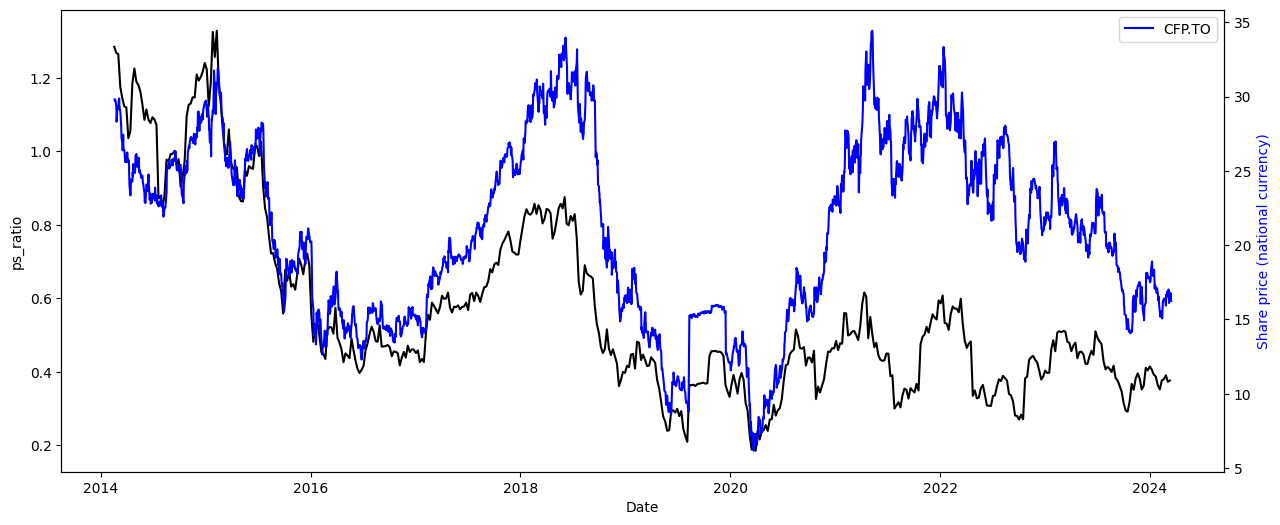

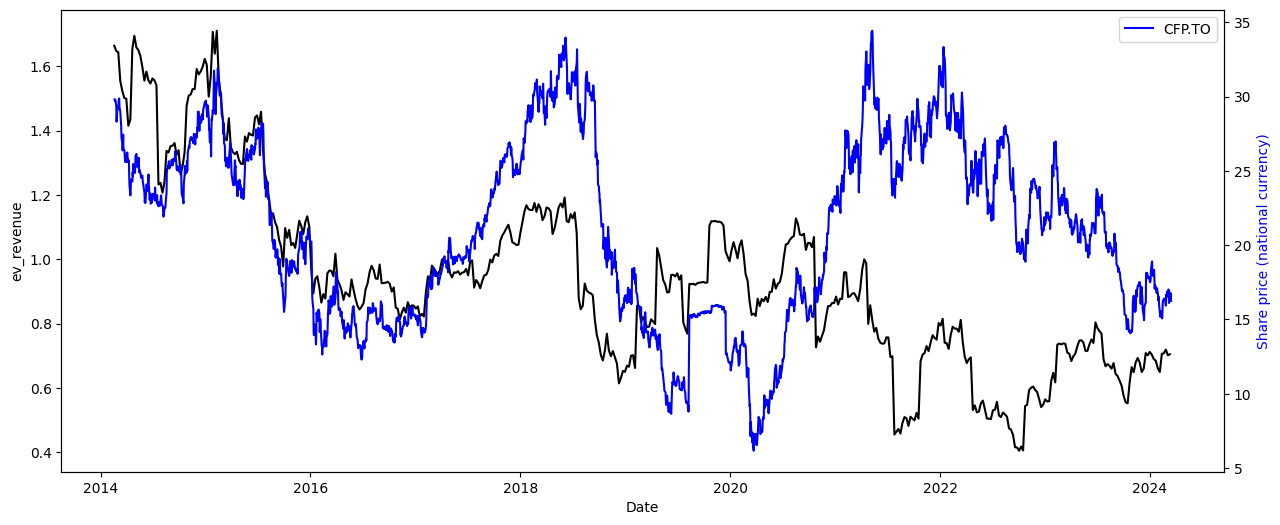

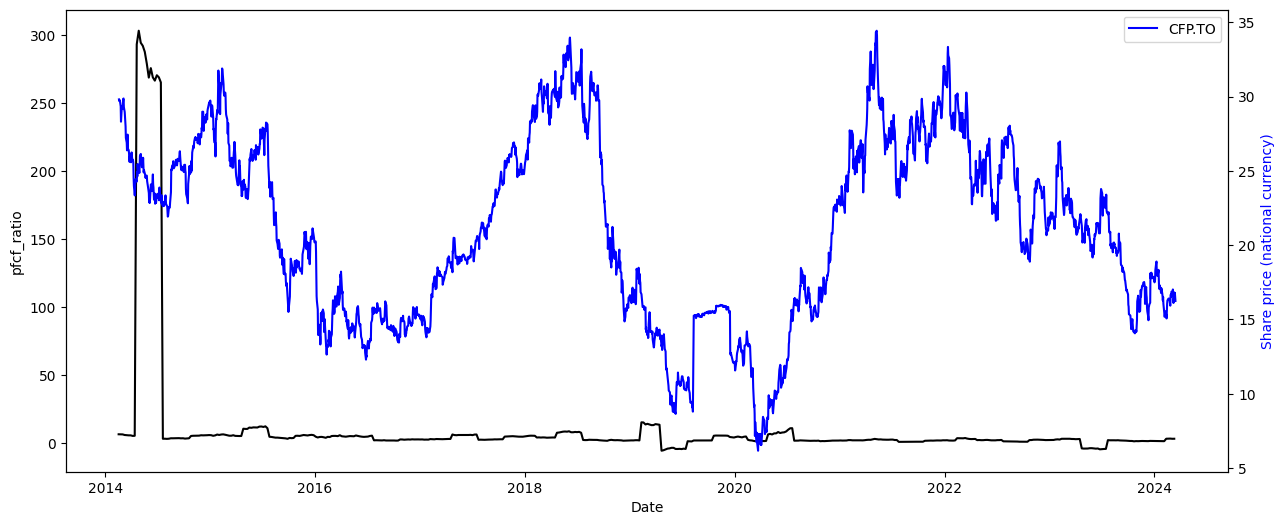

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

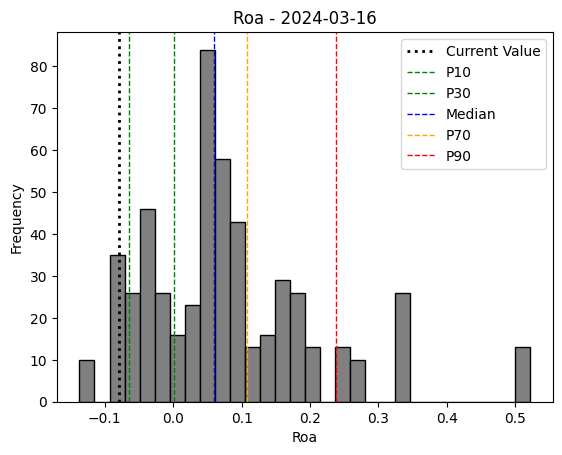

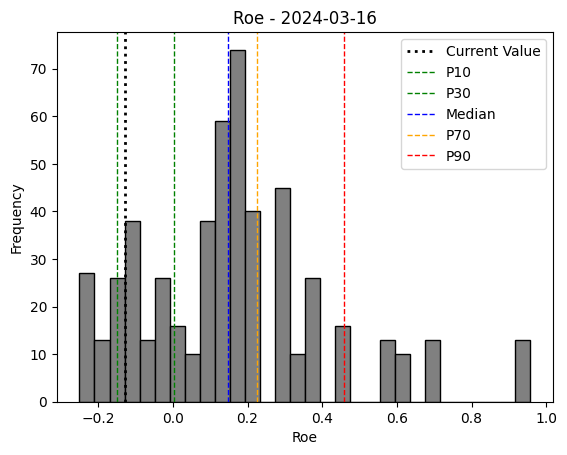

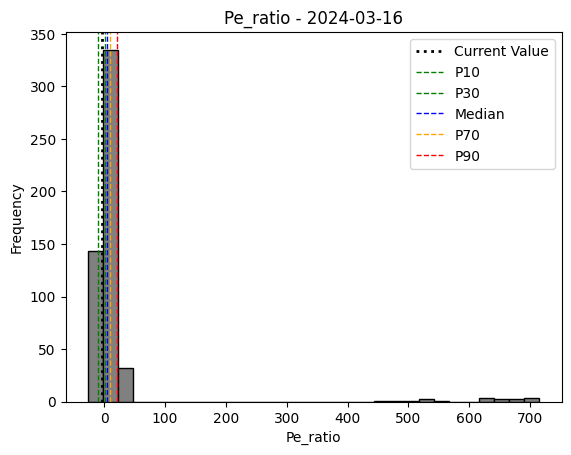

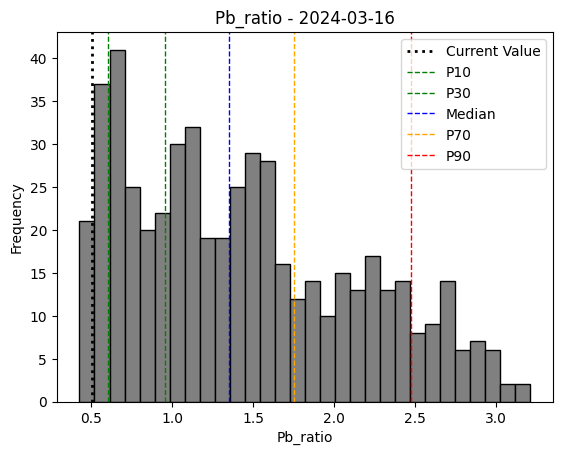

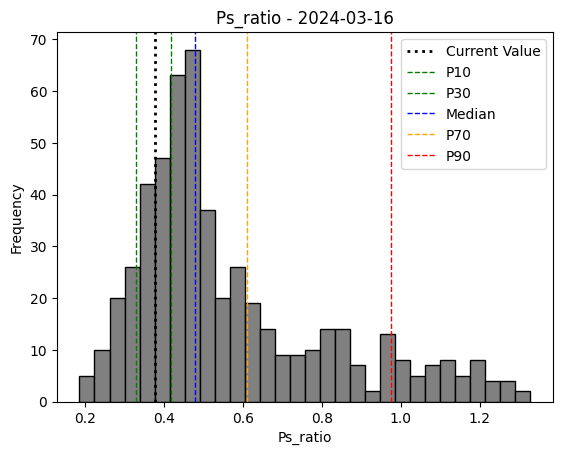

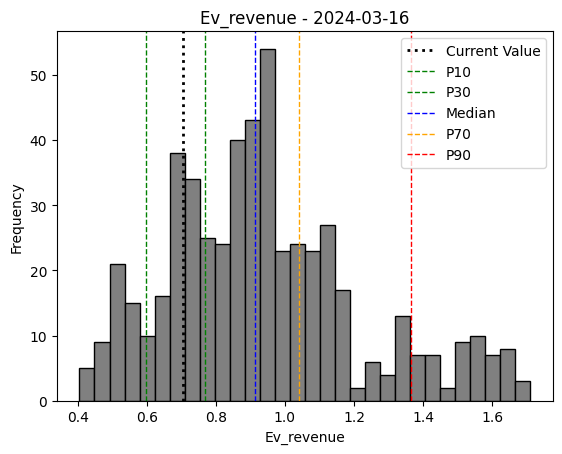

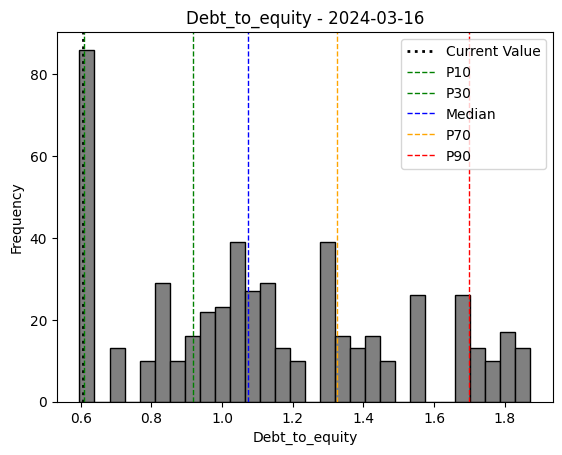

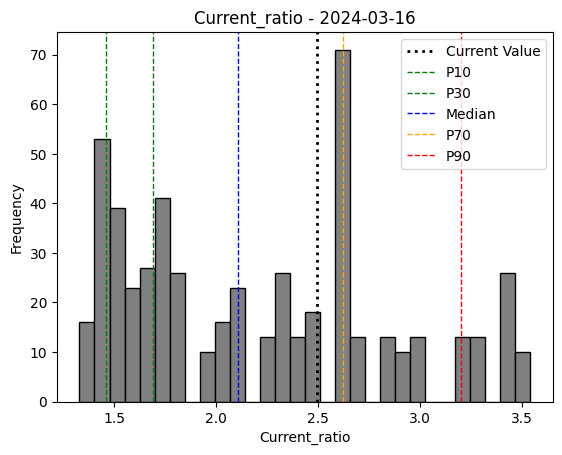

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.988447,-0.086888,0.145225,0.025867,-0.226742,-0.248181,0.210401
roe,0.988447,1.000000,-0.084496,0.190668,0.064015,-0.192099,-0.243536,0.198917
pe_ratio,-0.086888,-0.084496,1.000000,0.178536,0.106457,0.121491,0.084447,-0.263493
pb_ratio,0.145225,0.190668,0.178536,1.000000,0.919682,0.869346,0.163800,-0.349893
ps_ratio,0.025867,0.064015,0.106457,0.919682,1.000000,0.871750,-0.101264,-0.129200
ev_revenue,-0.226742,-0.192099,0.121491,0.869346,0.871750,1.000000,0.353789,-0.509060
debt_to_equity,-0.248181,-0.243536,0.084447,0.163800,-0.101264,0.353789,1.000000,-0.840827
current_ratio,0.210401,0.198917,-0.263493,-0.349893,-0.129200,-0.509060,-0.840827,1.000000


0 timestemos have been found!


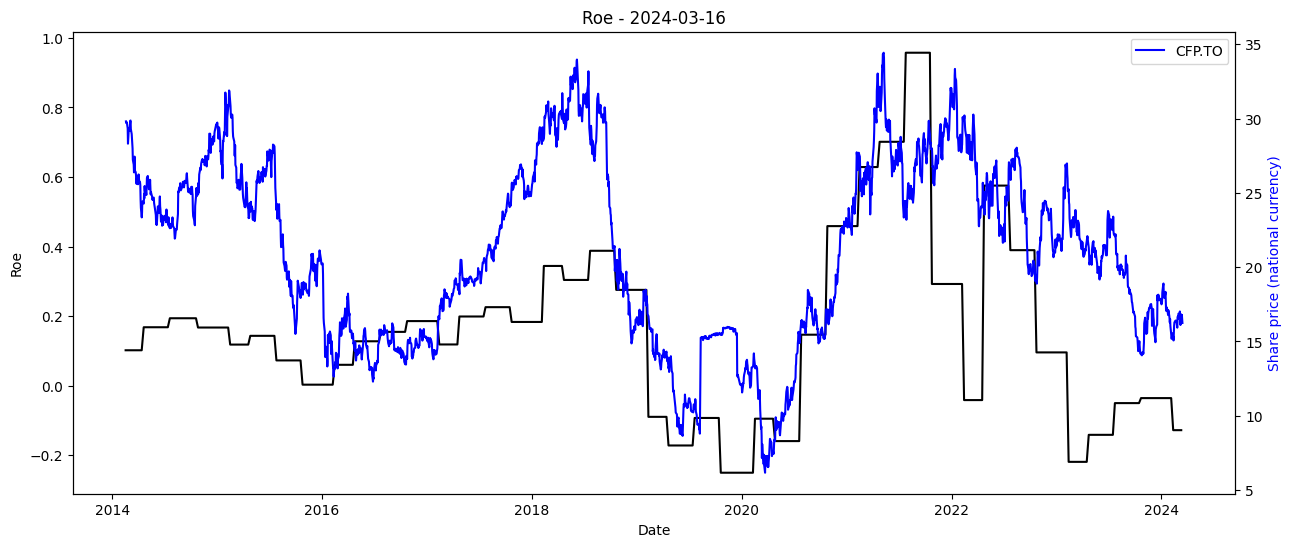

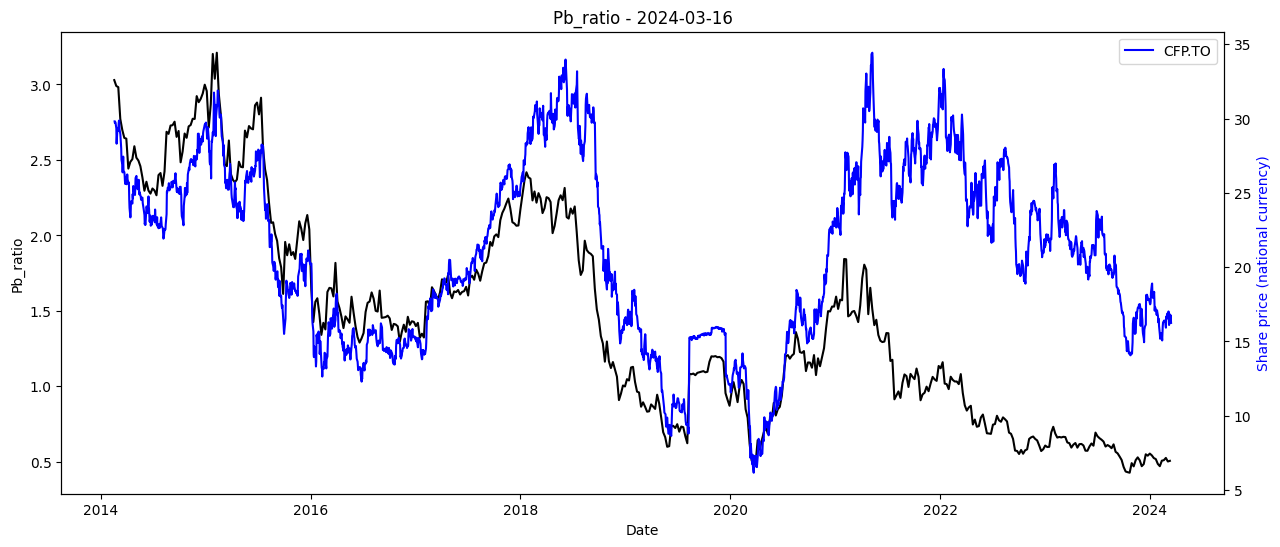

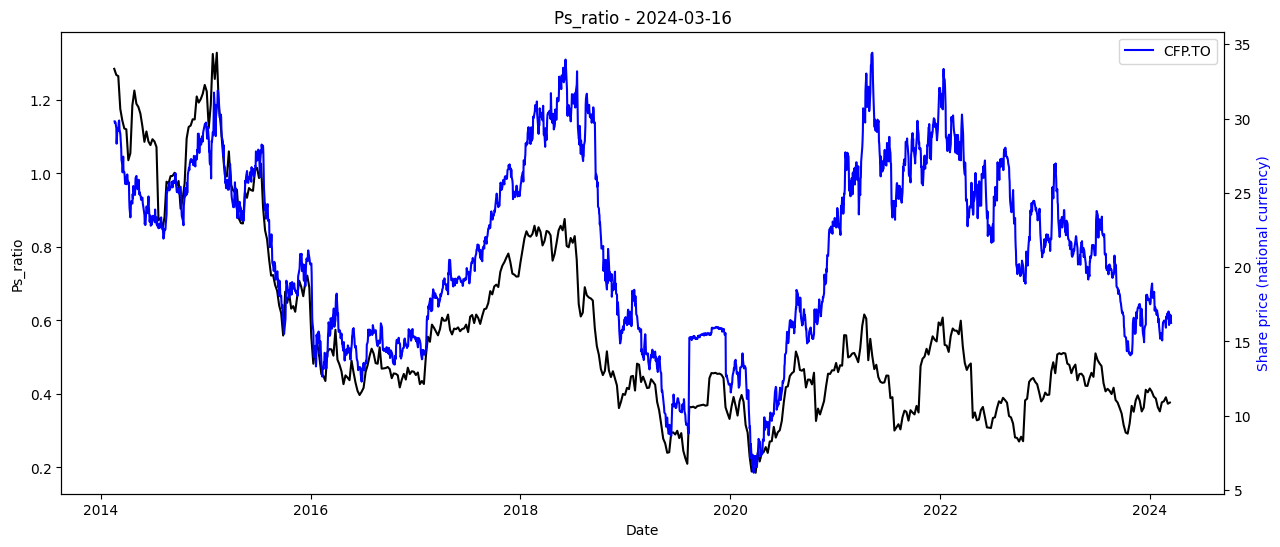

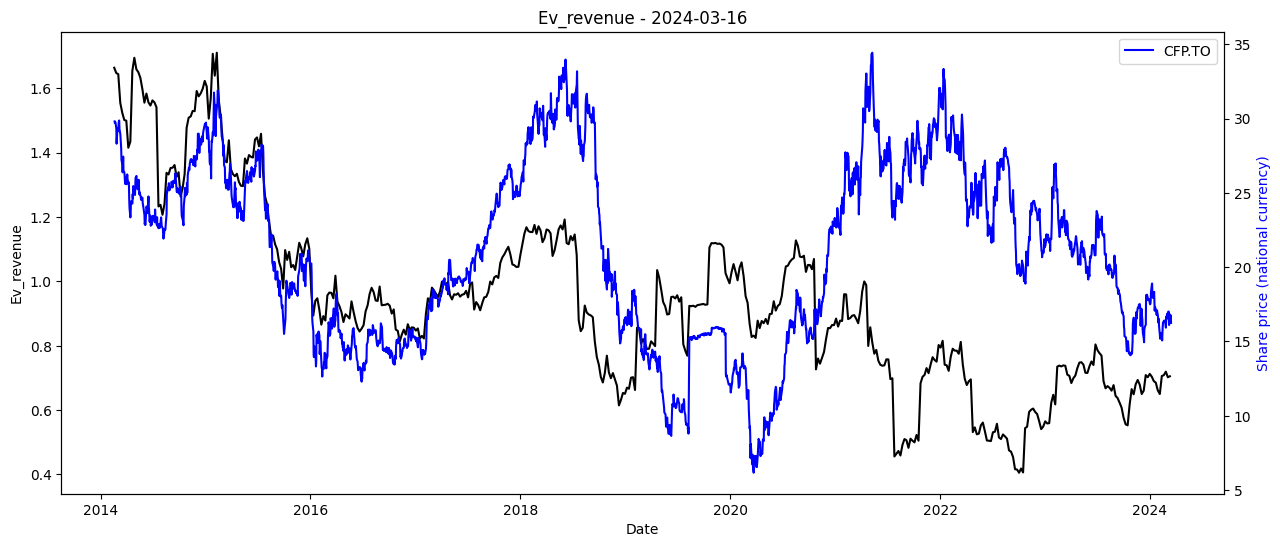

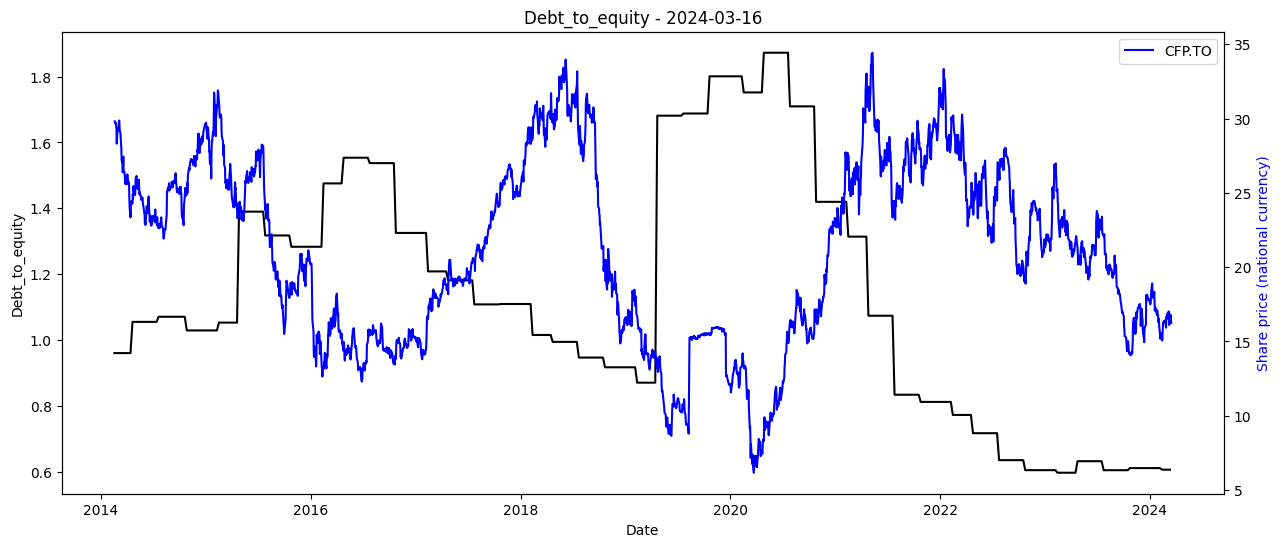

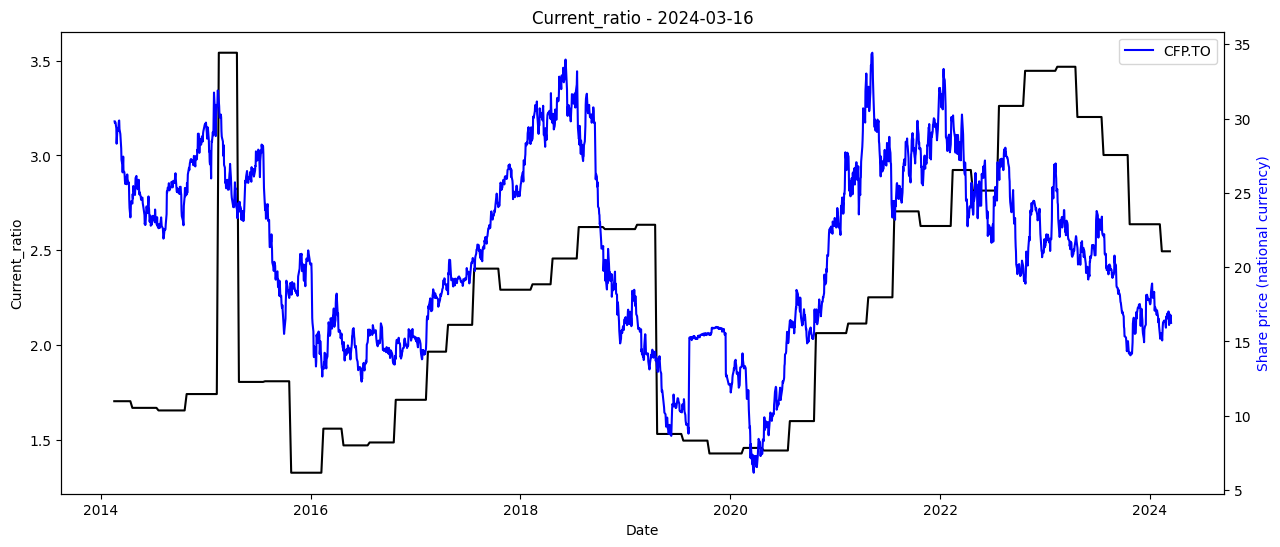

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )